In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor #ToTensor is 20 dimension matrix

# Preparing the dataset

In [ ]:
train_data = datasets.EMNIST(
    root = "data",
    split = "digits",
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.EMNIST(
    root = "data",
    split = "digits",
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 562M/562M [00:08<00:00, 65.8MB/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [ ]:
train_data

Dataset EMNIST
    Number of datapoints: 240000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset EMNIST
    Number of datapoints: 40000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_data.data.shape

torch.Size([240000, 28, 28])

In [ ]:
test_data.data.shape

torch.Size([40000, 28, 28])

In [ ]:
train_data.targets.size()

torch.Size([240000])

In [ ]:
train_data.targets

tensor([8, 9, 6,  ..., 1, 1, 0])

# Process the data into batches

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train': DataLoader(train_data,
                        batch_size = 100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                        batch_size = 100,
                        shuffle=True,
                        num_workers=1)
}


In [ ]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x79c2a3fcb9d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x79c2a3fcaaa0>}

# Structure of CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional 2d Layer
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #(Channel in, Channel out)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() #Regulirazation layer -> deactivates certain nodes at the network so that we don't always use them during training.

        # Fully Connected Layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10) #last layer should be 10 as it goes from 0 to 9.

    #Calling the Activation function
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #Calling reLu and max_pooling func
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #Call the dropout function
        x = x.view(-1,320) #20*4*4 neurons
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # calling dropout func only during training
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) #dim=1 #Probability for each individual digit.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #to make it work faster.

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_indx,(data,target) in enumerate (loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() #Set the gradient to zero  before we do th eback propogation
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward() #Calculate the gradient
    optimizer.step() #Update the weights
    if batch_indx % 20 == 0:
      print(f'Train Epoch: {epoch} [{batch_indx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_indx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')
def test():
  model.eval()
  test_loss =0
  correct = 0
  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1] # maximum value is the prediction
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loaders['test'].dataset)
  print(f'\n Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n')

In [ ]:
for epoch in range(1,11):
  train(epoch)
  test()

Train Epoch: 1 [0/240000 (0%)]	2.323893
Train Epoch: 1 [2000/240000 (1%)]	2.169727
Train Epoch: 1 [4000/240000 (2%)]	1.810960
Train Epoch: 1 [6000/240000 (2%)]	1.198913
Train Epoch: 1 [8000/240000 (3%)]	0.851075
Train Epoch: 1 [10000/240000 (4%)]	0.893105
Train Epoch: 1 [12000/240000 (5%)]	0.741599
Train Epoch: 1 [14000/240000 (6%)]	0.612798
Train Epoch: 1 [16000/240000 (7%)]	0.738736
Train Epoch: 1 [18000/240000 (8%)]	0.559825
Train Epoch: 1 [20000/240000 (8%)]	0.572712
Train Epoch: 1 [22000/240000 (9%)]	0.659839
Train Epoch: 1 [24000/240000 (10%)]	0.479043
Train Epoch: 1 [26000/240000 (11%)]	0.514519
Train Epoch: 1 [28000/240000 (12%)]	0.630239
Train Epoch: 1 [30000/240000 (12%)]	0.475065
Train Epoch: 1 [32000/240000 (13%)]	0.447021
Train Epoch: 1 [34000/240000 (14%)]	0.544088
Train Epoch: 1 [36000/240000 (15%)]	0.422069
Train Epoch: 1 [38000/240000 (16%)]	0.382680
Train Epoch: 1 [40000/240000 (17%)]	0.388756
Train Epoch: 1 [42000/240000 (18%)]	0.508697
Train Epoch: 1 [44000/240000 (

In [ ]:
device

device(type='cpu')

Prediction: 0


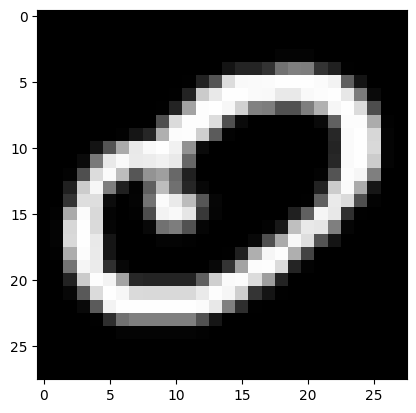

In [ ]:
import matplotlib.pyplot as plt
model.eval()

data , target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

pred = output.data.argmax(dim = 1, keepdim=True).item()

print(f'Prediction: {pred}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

Prediction: 9


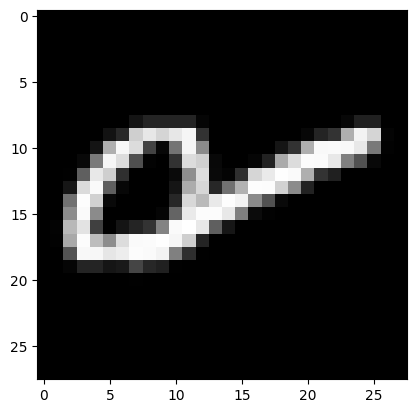

In [ ]:
model.eval()

data , target = test_data[1]

data = data.unsqueeze(0).to(device)

output = model(data)

pred = output.data.argmax(dim = 1, keepdim=True).item()

print(f'Prediction: {pred}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()